<a href="https://colab.research.google.com/github/ds777/sample-datasets/blob/master/701_exploratory_spatial_data_analysis_of_nepal_districts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory spatial data analysis (ESDA) of Nepal districts

## Install libraries

In [0]:
!pip install -q geopandas
!pip install -q libpysal
!pip install -q mapclassify
!pip install -q splot
!pip install -q legendgram
!pip install -q esda
!pip install -q inequality
!pip install -q giddy
!pip install -q ipywidgets 

## Load libraries

In [0]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from libpysal import examples
from libpysal.weights.contiguity import Queen
from libpysal import weights


from giddy.directional import Rose

import splot
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

import esda
from esda.moran import Moran
from esda.moran import Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV


from ipywidgets import interact, fixed
import ipywidgets as widgets

from scipy.stats.kde import gaussian_kde

import os

#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-darkgrid')
#plt.style.use('seaborn-dark')
#plt.style.use('bmh')

## Data prepration

### Import datasets

In [37]:
# Clone entire Github repository
!git clone -l -s git://github.com/ds777/sample-datasets.git cloned-repo
%cd cloned-repo
# Show contents of repo
#!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 115 (delta 13), reused 18 (delta 5), pack-reused 84
Receiving objects: 100% (115/115), 80.48 MiB | 35.57 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/cloned-repo/cloned-repo/cloned-repo


In [38]:
# read shapefile 
df = gpd.read_file("NapalAid.shp")
df

,id,id_1,name_1,id_2,name_2,id_3,district,depecprov,povindex,pcinc,pcincppp,pcincmp,malkids,lif40,nosafh20,population,boyg1_5,girlg1_5,kids1_5,schoolcnt,schlpkid,schlppop,ad_illit,ad_ilgt50,lon,lat,geometry
0,1.0,0.0,None,8.0,Dhaualagiri,60.0,Baglung,27.01,27.33,354.0,573.0,25613.0,42.9,8.52,11.12,250065.0,29144.0,31123.0,60267.0,554.0,9.1924,2.215424,34.46,0.0,83.252444,28.347313,"POLYGON ((83.10834 28.62020, 83.10560 28.60976..."
1,2.0,0.0,None,8.0,Dhaualagiri,61.0,Mustang,31.51,31.16,1189.0,1922.0,85957.0,54.7,12.02,8.32,11585.0,784.0,806.0,1590.0,70.0,44.0252,6.042296,38.65,0.0,83.859902,28.981165,"POLYGON ((83.99726 29.31675, 84.00000 29.31576..."
2,3.0,0.0,None,8.0,Dhaualagiri,62.0,Myagdi,30.03,28.54,636.0,1028.0,45986.0,47.5,7.27,12.56,109598.0,9035.0,9033.0,18068.0,273.0,15.1096,2.490921,34.84,0.0,83.461955,28.552960,"POLYGON ((83.50688 28.79306, 83.51024 28.78809..."
3,4.0,0.0,None,8.0,Dhaualagiri,63.0,Parbat,21.84,24.62,627.0,1013.0,45289.0,26.2,6.11,17.47,145657.0,11202.0,11280.0,22482.0,369.0,16.4131,2.533349,32.43,0.0,83.680893,28.211019,"POLYGON ((83.70261 28.39837, 83.70435 28.39452..."
4,5.0,1.0,Central,1.0,Bagmati,1.0,Bhaktapur,22.58,19.43,854.0,1379.0,61686.0,26.9,3.31,18.25,296705.0,16533.0,15271.0,31804.0,355.0,11.1621,1.196475,21.87,0.0,85.442906,27.677353,"POLYGON ((85.52173 27.71822, 85.52359 27.71375..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71.0,5.0,West,14.0,Lumbini,70.0,Arghakhanchi,27.24,27.37,562.0,909.0,40635.0,31.0,7.71,23.48,196873.0,18893.0,18594.0,37487.0,451.0,12.0308,2.290817,34.43,0.0,83.081325,27.908351,"POLYGON ((83.02333 28.10508, 83.02967 28.09924..."
71,72.0,5.0,West,14.0,Lumbini,71.0,Gulmi,27.36,27.42,465.0,752.0,33625.0,43.3,8.26,11.42,279005.0,24865.0,24999.0,49864.0,615.0,12.3335,2.204262,34.42,0.0,83.309026,28.093708,"POLYGON ((83.19185 28.26453, 83.20638 28.25558..."
72,73.0,5.0,West,14.0,Lumbini,73.0,Nawalparasi,26.01,27.99,716.0,1157.0,51742.0,38.9,8.09,13.11,638836.0,52014.0,51413.0,103427.0,706.0,6.8261,1.105135,36.25,0.0,83.955312,27.633575,"POLYGON ((84.10302 27.86387, 84.09755 27.85927..."
73,74.0,5.0,West,14.0,Lumbini,74.0,Palpa,28.42,25.23,609.0,985.0,44031.0,35.9,7.25,20.93,258842.0,22180.0,21734.0,43914.0,496.0,11.2948,1.916227,29.18,0.0,83.625682,27.817122,"POLYGON ((83.37988 27.95869, 83.37875 27.95583..."


- DepEcProv:  Deprivation in economic provisioning
- PovIndex:	  Human Poverty Index
- PCInc:	    Per Capita Income
- PCIncPPP:	  Per Capita Income PPP
- PCIncMP:  	Per capita income, Rs. at market price
- MalKids:	  Percentage of children under age five who are malnourished
- Lif40:	    Percentage of People not expected to survive age 40
- NoSafH20:  	Percentage without safe water
- Population:	Population
- BoyG1_5:	  Number of Boys Enrolled in Grade 1-5 (2012-2013)
- GirlG1_5:	  Number of Girls Enrolled in Grade 1-5 (2012-2013)
- KIDS1_5:	  Number of Children Enrolled in Grade 1-5 (2012-2013)
- SchoolCnt: 	Number of Schools (2012-2013)
- SCHLPKID:	  Number of Schools per child (in thousands) (2012-2013)
- SCHLPPOP:	  Number of Schools per population (in thousands) (2012-2013)
- AD_ILLIT:	  Adult illiteracy rate (2011)
- AD_ILGT50:  Dummy variable with value of 1 if adult illiteracy rate >50% (2011)
- VotNum:   	Number of Voters (lunar years 2047-2063, approx. 1991 to 2006)
- TotEcFMS: 	Total economy including financial intermediation service indirectly measured (total value added)
- XXCAmt:	    Project Sector Committed Amount: XX = sector (see above)	Project Data from AidData Aggregated to District
- XXDAmt:	    Project Sector Distributed Amount: XX = sector: Agriculture, Business Banking, Communication, Conflict Resolution, Budget Support + Finance, Education, Energy, Environment, Forestry, Gov + Civil Society, Health, Humanitarian Aid, Industry, Multi-Sector, Social Infrastructure, Tourism, Transport + Storage, Water Sanitation, Total

## Plot choroplet map

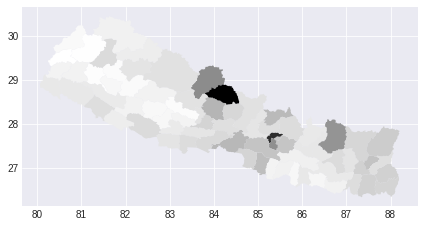

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
df.plot(column="pcincppp", ax=ax)
plt.tight_layout()
plt.show()

## Spatial Weights and Spatial Lag

In [40]:
# Spatial weights
w = Queen.from_dataframe(df, idVariable="id" )
w.transform = "R"
w

In [0]:
# Spatial lag
df["w_pcincppp"] = weights.lag_spatial(w, df["pcincppp"])

In [42]:
df["w_pcincppp"].head()

0     816.500000
1    1744.666667
2    1436.714286
3    1025.800000
4    2019.000000
Name: w_pcincppp, dtype: float64

In [43]:
df["pcincppp"].head()

0     573.0
1    1922.0
2    1028.0
3    1013.0
4    1379.0
Name: pcincppp, dtype: float64

## Global Spatial Autocorrelation


In [44]:
# calculate global Moran
y = df["pcincppp"]
moran = Moran(y, w)
moran.I

0.38453969348086553

In [45]:
# compute p-value (via simulation)
moran.p_sim

0.001

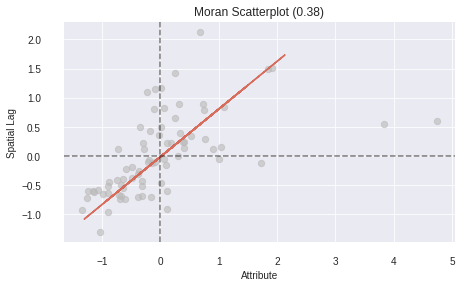

In [46]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.savefig("scatter-moran.png")
plt.show()

## Local Spatial Autocorrelation


In [0]:
# calculate local Moran
m_local = Moran_Local(y, w)

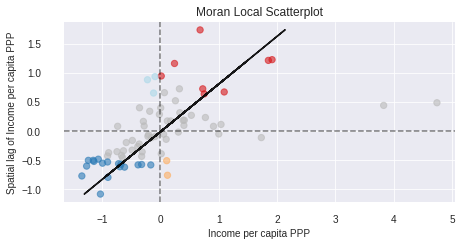

In [48]:
# Plot
fig, ax = moran_scatterplot(m_local, p=0.05)
ax.set_xlabel('Income per capita PPP')
ax.set_ylabel('Spatial lag of Income per capita PPP')
plt.show()

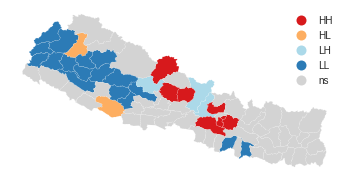

In [49]:
# Map
fig, ax = plt.subplots(figsize=(6,4))
lisa_cluster(m_local, df, p=0.05, ax=ax)
plt.show()